# Table of Contents
 <p>

In [140]:
#from planet4 import io, region_data, markings
# from p4_tools import get_final_markings_counts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import root, curve_fit, leastsq
import pdb
import shapely.geometry as shp
#import fiona as fio
from shapely import affinity
from shapely.ops import cascaded_union, unary_union
import time

In [208]:
# read out metadata for season 2 and 3
meta = pd.read_csv('inca_metadata.csv')

# read out actual markings for fans and blotches, both seasons combined
fans = pd.read_csv('inca_fans.csv')
blotches = pd.read_csv('inca_blotches.csv')

# read out tile coordinate data
tiles = pd.read_csv('inca_tile_coords.csv')

In [209]:
# find unique obsids in the fans and blotches catalogs
fimg_names = fans.image_name.unique()
bimg_names = blotches.image_name.unique()
fimg_id = fans.image_id.unique()
bimg_id = blotches.image_id.unique()

pd.set_option('max_columns', 40)

fans = fans.merge(tiles)
blotches = blotches.merge(tiles)

blotches['area'] = np.pi * blotches.radius_1 * blotches.radius_2

for frame in [fans, blotches]:
    frame['tile_lat'] = frame['PlanetocentricLatitude']
    frame['tile_lon'] = frame['PositiveEast360Longitude']
    frame['image_id'] = frame['image_id']


In [210]:
# find what size fans should be removed for fair comparison
min_fan_pixels = fans.distance.min()
min_bl_area = blotches.area.min()

max_scale = np.max( meta.map_scale.max() )
print('maximum map_scale:',  max_scale, '; min_fan_marking:', min_fan_pixels, '; min_bl_area:', min_bl_area)

# if the minimal fan marking tool is = 10 pixels at max_bin = 4, it will correspond to  
# min_fan_pixels * max_binning / image_binning
meta['min_fan'] = min_fan_pixels * meta.map_scale.max() // meta.map_scale + 1

# if the minimal blotch marking tool is = 80 sq. pixels at max_bin = 4, it will correspond to  
# min_bl_area * max_binning^2 / image_binning^2
meta['min_bl'] = min_bl_area * meta.map_scale.max()**2 // meta.map_scale**2 + 1


maximum map_scale: 1.0 ; min_fan_marking: 10.0 ; min_bl_area: 314.159265359


In [211]:
blotches = blotches.merge(meta)
fans = fans.merge(meta)
blotches['type'] = 'b'
fans['type'] = 'f'

blotches['valid_marking'] = blotches.area > blotches.min_bl
fans['valid_marking'] = fans.distance > fans.min_fan

true_fans = fans[fans.valid_marking==True]
true_blotches = blotches[blotches.valid_marking==True]

In [212]:
objects = pd.concat([true_fans, true_blotches])
objects.head()

,PlanetocentricLatitude,PlanetographicLatitude,PositiveEast360Longitude,Unnamed: 0,angle,area,binning,distance,image_id,image_name,image_x,image_y,invalids,l_s,line_samples,lines,map_scale,min_bl,min_fan,n_votes,...,radius_1,radius_2,real_area,season,spread,tile_lat,tile_lon,type,valid_marking,version,vote_ratio,x,x_angle,x_hirise,x_tile,xy_hirise,y,y_angle,y_hirise,y_tile
0,-81.29131,-81.391987,296.00677,2644,53.385830,NaN,"[-9998, -9998, -9998, -9998, 2, 2, -9998, -999...",97.199588,APF00001wg,ESP_011491_0985,265.069271,39412.967620,0.827704,187.478012,68907,15003,0.5,1257.0,21.0,23,...,NaN,NaN,4.453036e+07,season2,18.562838,-81.29131,296.00677,f,True,1.0,NaN,265.069271,0.587475,420.0,1,"(420.0, 39232.0)",504.967620,0.790627,39232.0,72
1,-81.29131,-81.391987,296.00677,2644,48.048329,NaN,"[-9998, -9998, -9998, -9998, 2, 2, -9998, -999...",82.124666,APF00001wg,ESP_011491_0985,398.417188,39414.206417,0.827704,187.478012,68907,15003,0.5,1257.0,21.0,19,...,NaN,NaN,4.453036e+07,season2,30.619872,-81.29131,296.00677,f,True,1.0,NaN,398.417188,0.664924,420.0,1,"(420.0, 39232.0)",506.206417,0.739726,39232.0,72
2,-81.29131,-81.391987,296.00677,2644,44.600405,NaN,"[-9998, -9998, -9998, -9998, 2, 2, -9998, -999...",118.157943,APF00001wg,ESP_011491_0985,258.242535,39185.726441,0.827704,187.478012,68907,15003,0.5,1257.0,21.0,21,...,NaN,NaN,4.453036e+07,season2,17.102321,-81.29131,296.00677,f,True,1.0,NaN,258.242535,0.710171,420.0,1,"(420.0, 39232.0)",277.726441,0.700333,39232.0,72
3,-81.29131,-81.391987,296.00677,2644,37.936710,NaN,"[-9998, -9998, -9998, -9998, 2, 2, -9998, -999...",120.448379,APF00001wg,ESP_011491_0985,133.749250,38949.274561,0.827704,187.478012,68907,15003,0.5,1257.0,21.0,7,...,NaN,NaN,4.453036e+07,season2,28.439226,-81.29131,296.00677,f,True,1.0,NaN,133.749250,0.778927,420.0,1,"(420.0, 39232.0)",41.274561,0.607180,39232.0,72
4,-81.29131,-81.391987,296.00677,2644,51.724405,NaN,"[-9998, -9998, -9998, -9998, 2, 2, -9998, -999...",188.733132,APF00001wg,ESP_011491_0985,127.561188,39080.980482,0.827704,187.478012,68907,15003,0.5,1257.0,21.0,4,...,NaN,NaN,4.453036e+07,season2,28.363391,-81.29131,296.00677,f,True,1.0,NaN,127.561188,0.612441,420.0,1,"(420.0, 39232.0)",172.980482,0.776165,39232.0,72


In [213]:

objects.rename(columns={'image_name':'name'}, inplace=True)
# objects.binning.iloc[0]
# def get_bins(binning):
#     arr = np.fromstring(binning.strip('[]'), dtype=np.int, sep=',')
#     return arr[4]
# objects.head(4)

In [214]:
# get list of unique images
img_unique = objects.name.unique()

# add columns for coverage and season in the meta dataframe
# meta['coverage'] = 0
# meta['coverage_redundant'] = 0


# record type of each object - they are still in order from concatenation so this can be done with indexing
# split = len(fans.valid_marking[fans.valid_marking==True])
# objects.loc[:split,'type'] = 'f'
# objects.loc[split:,'type'] = 'b'

#re-sort objects according to image, so that blotches and fans for the same image won't be split up
objects = objects.sort_values(by='name').reset_index(drop=True)
meta = meta.sort_values(by='obsid').reset_index(drop=True)
objects.shape

(23771, 43)

In [215]:
%matplotlib inline

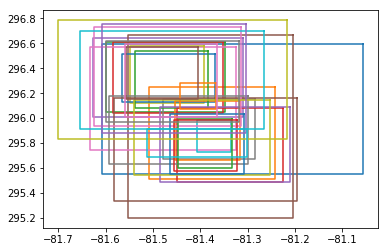

In [216]:
# create a list to store points corresponding to the corners (bounds) of each HiRise image
# and a list to store the polygons made from the sets of points
points = [None] * 4
img_shapes = [None] * len(img_unique)
plt.figure(1)
for i,img_name in enumerate(img_unique):
    df = objects.query('name==@img_name')
    boundshi = df.tile_lat.max()
    boundsri = df.tile_lon.max()
    boundslo = df.tile_lat.min()
    boundsle = df.tile_lon.min()
    points[0] = (boundshi,boundsri)
    points[1] = (boundslo,boundsri)
    points[2] = (boundslo,boundsle)
    points[3] = (boundshi,boundsle)
    img_shapes[i] = shp.Polygon(points[:])
    # plot the outlines of the HiRise images as an example
    x,y = img_shapes[i].exterior.xy
    plt.plot(x,y);
    

In [217]:
# create arrays to store info on non-overlapping images
misses = np.zeros((len(img_unique),len(img_unique)))
ind2drop = np.zeros((len(img_unique)),dtype=int)

# loop through images
for i in range(len(img_unique)):
    # loop through other images to check image [i]
    for j in range(len(img_unique)-i-1):
        # check if image[i] intersects the current image, if not, add a 1 in 'misses' array 
        # with index corresponding to the two non-overlapping images
        if img_shapes[i].intersects(img_shapes[i+j+1])==False:
            misses[i,i+j+1] = 1 

# loop through possible cases of non-overlap
for n in range(len(img_unique)):
    # if all images intersect somewhwere, misses will be only zeros and the loop should be broken
    if np.sum(misses)==0:
        break
    # get indices of flags in 'misses'
    miss_inds = np.where(misses!=0)
    # get which images were involved, sort by involvement
    miss_unique = np.unique(miss_inds,return_counts=True)
    # find which image came up the most in 'misses' - this is the one to remove next iteration
    miss_max = max(miss_unique[1])
    miss_max_ind = np.where(miss_unique[1]==miss_max)[0][0]
    # get the index of that image in the collection of polygons 'img_shapes', add one so that 
    # the index '0' wouldn't get missed
    ind2drop[n] = int(miss_unique[0][miss_max_ind]) + 1
    # clear 'misses' of any flags corresponding to that image becuase it has been found all ready
    misses[:,int(ind2drop[n])-1] = 0
    misses[int(ind2drop[n])-1,:] = 0

In [218]:
# trim off excess zeroes in 'ind2drop'
ind2drop = np.delete(ind2drop,np.where(ind2drop==0.0))

# 'safe' is 1 where the index refers to an object to-be-dropped, and 0 otherwise (zeroes are safe objects)
safe = np.zeros((len(img_unique)))
safe[ind2drop-1] = 1

# 'safes' are the indices of all safe objects, the first of which is the starting point for the next loop,
# which is necessary to know in cases where the first few images are to-be-dropped
safes = np.where(safe==0)
start = int(safes[0][0])

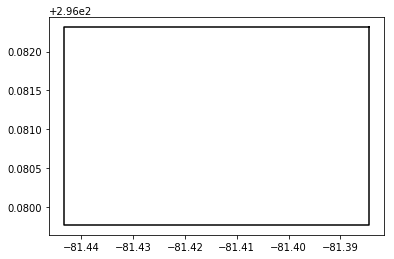

In [219]:
# loop through images to define area with highest degree of overlap
for i in range(len(img_unique)):
    # first iteration - intersection of first and second object is the temporary object
    if i == 0:
        inter_temp = img_shapes[i].intersection(img_shapes[i+1])
        # if '0' or '1' is an index-to-drop, temporary object is just the first safe object
        if any([z-1==i for z in ind2drop]) or any([z-1==i+1 for z in ind2drop]):
            inter_temp = img_shapes[start]
        continue
    # if this is the last iteration, temporary object is the final object
    elif i == (len(img_unique)-1):
        inter = inter_temp
        break
    # if the loop is on an index-to-drop, continue to next iteration, omitting this object
    # from the calculation of 'inter'
    elif any([z-1==i+1 for z in ind2drop])==True:
        continue
    # normal action - update temporary object as intersection with the next object in 'img_shapes'
    else:
        inter_temp = inter_temp.intersection(img_shapes[i+1])

# plot the outline of the most overlapped area found in black, should look reasonable on previous plot
xi,yi = inter.exterior.xy
plt.plot(xi,yi,'k')
plt.show()

In [220]:
# 'buffer' is a factor that determines how far inside or outside the extents of 'inter' an object's tile's 
# must be to be considered for calculation. a positive number allows objects outside 'inter' to be considered
buffer = .0005
# define lat/lon corresponding to corners of 'inter'
lo_lat = xi[2] * (1. + buffer)
hi_lat = xi[0] * (1. - buffer)
lo_lon = yi[0] * (1. - buffer)
hi_lon = yi[2] * (1. + buffer)

# 'overlap_objs' are all the objects whose tile center is within the allowable distance around 'inter'
overlap_objs = objects.loc[(objects['tile_lat'] > lo_lat) & (objects['tile_lon'] < hi_lon) & (objects['tile_lat'] < hi_lat) & (objects['tile_lon'] > lo_lon)]
overlap_objs = overlap_objs.reset_index(drop=True)
ol_img_unique = overlap_objs.name.unique()

In [221]:
overlap_objs.shape

(5606, 43)

In [222]:
# create arrays to be filled
n_ol_img = len(ol_img_unique)
n_marks = np.zeros((n_ol_img,3))
n_objs = overlap_objs.name.value_counts()[0]
img_fans = np.zeros((n_ol_img,n_objs))
img_blotches = np.zeros((n_ol_img,n_objs))
f_histmax = np.zeros((n_ol_img))
b_histmax = np.zeros((n_ol_img))
collection = [None] * len(overlap_objs)
points = [None] * 14
areas = np.zeros(len(overlap_objs))
img_areas = np.zeros(len(ol_img_unique))
tile_log = []

overlap_objs.head(10)

,PlanetocentricLatitude,PlanetographicLatitude,PositiveEast360Longitude,Unnamed: 0,angle,area,binning,distance,image_id,name,image_x,image_y,invalids,l_s,line_samples,lines,map_scale,min_bl,min_fan,n_votes,...,radius_1,radius_2,real_area,season,spread,tile_lat,tile_lon,type,valid_marking,version,vote_ratio,x,x_angle,x_hirise,x_tile,xy_hirise,y,y_angle,y_hirise,y_tile
0,-81.435117,-81.534181,296.226401,2739,72.151980,1402.047766,"[-9998, -9998, -9998, -9998, 2, 2, -9998, -999...",NaN,APF000020l,ESP_011491_0985,1410.414634,21647.769512,0.827704,187.478012,68907,15003,0.5,1257.0,21.0,41,...,25.353849,17.602284,4.453036e+07,season2,NaN,-81.435117,296.226401,b,True,NaN,NaN,670.414634,0.301802,1160.0,2,"(1160.0, 21696.0)",275.769512,0.917952,21696.0,40
1,-81.435117,-81.534181,296.226401,2739,80.577472,1549.718602,"[-9998, -9998, -9998, -9998, 2, 2, -9998, -999...",NaN,APF000020l,ESP_011491_0985,1226.403846,21476.290385,0.827704,187.478012,68907,15003,0.5,1257.0,21.0,26,...,27.205621,18.131943,4.453036e+07,season2,NaN,-81.435117,296.226401,b,True,NaN,0.624146,486.403846,0.170400,1160.0,2,"(1160.0, 21696.0)",104.290385,0.935978,21696.0,40
2,-81.375713,-81.475444,296.160440,2625,71.892303,1918.033731,"[-9998, -9998, -9998, -9998, 2, 2, -9998, -999...",NaN,APF000020q,ESP_011491_0985,116.604167,28572.145833,0.827704,187.478012,68907,15003,0.5,1257.0,21.0,32,...,27.921432,21.865967,4.453036e+07,season2,NaN,-81.375713,296.160440,b,True,NaN,NaN,116.604167,0.225816,420.0,1,"(420.0, 28820.0)",76.145833,0.625622,28820.0,53
3,-81.375713,-81.475444,296.160440,2625,8.441592,2451.244726,"[-9998, -9998, -9998, -9998, 2, 2, -9998, -999...",NaN,APF000020q,ESP_011491_0985,718.140350,28580.719298,0.827704,187.478012,68907,15003,0.5,1257.0,21.0,19,...,32.388053,24.090841,4.453036e+07,season2,NaN,-81.375713,296.160440,b,True,NaN,NaN,718.140350,0.272076,420.0,1,"(420.0, 28820.0)",84.719298,0.496952,28820.0,53
4,-81.375713,-81.475444,296.160440,2625,133.395174,8650.370483,"[-9998, -9998, -9998, -9998, 2, 2, -9998, -999...",NaN,APF000020q,ESP_011491_0985,815.547618,28915.619047,0.827704,187.478012,68907,15003,0.5,1257.0,21.0,14,...,61.337771,44.890748,4.453036e+07,season2,NaN,-81.375713,296.160440,b,True,NaN,NaN,815.547618,-0.461631,420.0,1,"(420.0, 28820.0)",419.619047,0.659913,28820.0,53
5,-81.375713,-81.475444,296.160440,2625,40.177207,8580.204896,"[-9998, -9998, -9998, -9998, 2, 2, -9998, -999...",NaN,APF000020q,ESP_011491_0985,698.962965,28581.000000,0.827704,187.478012,68907,15003,0.5,1257.0,21.0,9,...,60.018932,45.505042,4.453036e+07,season2,NaN,-81.375713,296.160440,b,True,NaN,NaN,698.962965,0.096044,420.0,1,"(420.0, 28820.0)",85.000000,0.637090,28820.0,53
6,-81.375713,-81.475444,296.160440,2625,131.401501,3275.154913,"[-9998, -9998, -9998, -9998, 2, 2, -9998, -999...",NaN,APF000020q,ESP_011491_0985,598.676768,29023.111111,0.827704,187.478012,68907,15003,0.5,1257.0,21.0,33,...,37.937557,27.479740,4.453036e+07,season2,NaN,-81.375713,296.160440,b,True,NaN,NaN,598.676768,-0.277412,420.0,1,"(420.0, 28820.0)",527.111111,0.666819,28820.0,53
7,-81.395113,-81.494626,296.153323,2748,150.444196,2031.442875,"[-9998, -9998, -9998, -9998, 2, 2, -9998, -999...",NaN,APF00001zw,ESP_011491_0985,1351.422988,26642.689655,0.827704,187.478012,68907,15003,0.5,1257.0,21.0,29,...,29.191963,22.150903,4.453036e+07,season2,NaN,-81.395113,296.153323,b,True,NaN,NaN,611.422988,-0.196699,1160.0,2,"(1160.0, 26628.0)",338.689655,0.555015,26628.0,49
8,-81.395113,-81.494626,296.153323,2748,28.464322,6503.280120,"[-9998, -9998, -9998, -9998, 2, 2, -9998, -999...",NaN,APF00001zw,ESP_011491_0985,1343.151111,26317.200000,0.827704,187.478012,68907,15003,0.5,1257.0,21.0,15,...,54.127993,38.243767,4.453036e+07,season2,NaN,-81.395113,296.153323,b,True,NaN,NaN,603.151111,0.705049,1160.0,2,"(1160.0, 26628.0)",13.200000,0.452894,26628.0,49
9,-81.344584,-81.444664,296.104208,2632,75.654362,13953.468732,"[-9998, -9998, -9998, -9998, 2, 2, -9998, -999...",NaN,APF00001zy,ESP_011491_0985,172.471427,

In [223]:
overlap_objs.name.value_counts()

ESP_012256_0985    705
ESP_013113_0985    563
ESP_011900_0985    536
ESP_020748_0985    337
ESP_021684_0985    330
ESP_021671_0985    286
ESP_020827_0985    275
ESP_012744_0985    245
ESP_021829_0985    229
ESP_021526_0985    220
ESP_013034_0985    206
ESP_011729_0985    199
ESP_012322_0985    162
ESP_021605_0985    140
ESP_011544_0985    132
ESP_011623_0985    130
ESP_012889_0985    123
ESP_011702_0985    105
ESP_020115_0985    103
ESP_011491_0985     99
ESP_020339_0985     92
ESP_021460_0985     86
ESP_012691_0985     78
ESP_011557_0985     76
ESP_020194_0985     74
ESP_020959_0985     62
ESP_012467_0985      7
ESP_020128_0985      6
Name: name, dtype: int64

In [224]:
for k in range(len(overlap_objs)):
    if overlap_objs.type[k]=='f':
        r = overlap_objs.distance[k]*np.tan((overlap_objs.spread[k]/2.)*np.pi/180.)
        red_ax = overlap_objs.distance[k] - r
        points[0] = (overlap_objs.image_x[k],overlap_objs.image_y[k])
        points[1] = (overlap_objs.image_x[k] + r,overlap_objs.image_y[k] + red_ax)
        points[2] = (overlap_objs.image_x[k] + r*np.cos(15.*np.pi/180.),overlap_objs.image_y[k] + r*np.sin(15.*np.pi/180.) + red_ax)
        points[3] = (overlap_objs.image_x[k] + r*np.cos(30.*np.pi/180.),overlap_objs.image_y[k] + r*np.sin(30.*np.pi/180.) + red_ax)
        points[4] = (overlap_objs.image_x[k] + r*np.cos(45.*np.pi/180.),overlap_objs.image_y[k] + r*np.sin(45.*np.pi/180.) + red_ax)
        points[5] = (overlap_objs.image_x[k] + r*np.cos(60.*np.pi/180.),overlap_objs.image_y[k] + r*np.sin(60.*np.pi/180.) + red_ax)
        points[6] = (overlap_objs.image_x[k] + r*np.cos(75.*np.pi/180.),overlap_objs.image_y[k] + r*np.sin(75.*np.pi/180.) + red_ax)
        points[7] = (overlap_objs.image_x[k] + r*np.cos(90.*np.pi/180.),overlap_objs.image_y[k] + r*np.sin(90.*np.pi/180.) + red_ax)
        points[8] = (overlap_objs.image_x[k] + r*np.cos(105.*np.pi/180.),overlap_objs.image_y[k] + r*np.sin(105.*np.pi/180.) + red_ax)
        points[9] = (overlap_objs.image_x[k] + r*np.cos(120.*np.pi/180.),overlap_objs.image_y[k] + r*np.sin(120.*np.pi/180.) + red_ax)
        points[10] = (overlap_objs.image_x[k] + r*np.cos(135.*np.pi/180.),overlap_objs.image_y[k] + r*np.sin(135.*np.pi/180.) + red_ax)
        points[11] = (overlap_objs.image_x[k] + r*np.cos(150.*np.pi/180.),overlap_objs.image_y[k] + r*np.sin(150.*np.pi/180.) + red_ax)
        points[12] = (overlap_objs.image_x[k] + r*np.cos(165.*np.pi/180.),overlap_objs.image_y[k] + r*np.sin(165.*np.pi/180.) + red_ax)
        points[13] = (overlap_objs.image_x[k] + r*np.cos(180.*np.pi/180.),overlap_objs.image_y[k] + r*np.sin(180.*np.pi/180.) + red_ax)
        collection[k] = shp.Polygon(points[:])
        collection[k] = affinity.rotate(collection[k],angle=overlap_objs.angle[k] - 90.,origin=points[0])
        areas[k] = collection[k].area
    else:
        circle = shp.point.Point(overlap_objs.image_x[k],overlap_objs.image_y[k]).buffer(1)
        collection[k] = affinity.scale(circle,overlap_objs.radius_1[k],overlap_objs.radius_2[k])
        collection[k] = affinity.rotate(collection[k],angle=overlap_objs.angle[k])
        areas[k] = collection[k].area

In [225]:
i = 0
overlap_objs.image_id[(overlap_objs.name==ol_img_unique[i])]

0     APF000020l
1     APF000020l
2     APF000020q
3     APF000020q
4     APF000020q
5     APF000020q
6     APF000020q
7     APF00001zw
8     APF00001zw
9     APF00001zy
10    APF00001zy
11    APF00001zy
12    APF00001zy
13    APF00001zy
14    APF00001zy
15    APF00001zy
16    APF00001zl
17    APF00001zl
18    APF00001zm
19    APF00001zl
20    APF00001zy
21    APF00001zy
22    APF0000202
23    APF0000202
24    APF0000205
25    APF0000205
26    APF0000205
27    APF00001zy
28    APF000022j
29    APF000022j
         ...    
69    APF00001z3
70    APF000020q
71    APF000020q
72    APF0000205
73    APF0000205
74    APF000020l
75    APF000020l
76    APF000022j
77    APF000022p
78    APF000022p
79    APF000022p
80    APF000022j
81    APF000022j
82    APF000022j
83    APF000022j
84    APF000022c
85    APF0000205
86    APF00001x2
87    APF00001x4
88    APF00001xi
89    APF00001xi
90    APF00001wm
91    APF00001wm
92    APF00001wm
93    APF00001wm
94    APF00001wm
95    APF00001wm
96    APF00001

In [226]:
tile_size = 544320

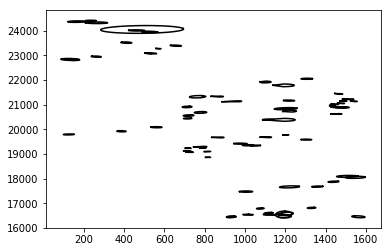

In [227]:
for i,img_name in enumerate(ol_img_unique):
    df = overlap_objs.query('name==@img_name')
    map_scale = meta.query('obsid==@img_name').map_scale.values[0]
    # get set of fans & blotches for each image, and get list of tiles in which these are contained
    fans_ = df.query('type=="f"')
    blotches_ = df.query('type=="b"')
    tile_log.append(df.image_id.unique())
    
    current_Ls = df.l_s.values[0]
#     # for each image, record l_s and the number of fans & blotches divided by the number of tiles considered
    if len(fans_) > 0 and len(blotches_) > 0:
        n_marks[i,0] = current_Ls
        try:
            n_marks[i,1] = len(fans_)/(fans_.image_id.nunique() * tile_size/10000 * (fans_.map_scale.reset_index(drop=True)[0])**2)
        except ZeroDivisionError:
            n_marks[i,1] = np.nan
        try:
            n_marks[i,2] = len(blotches_)/(blotches_.image_id.nunique() * tile_size/10000 * (blotches_.map_scale.reset_index(drop=True)[0])**2)
        except ZeroDivisionError:
            n_marks[i,2] = np.nan
    
    # get lengths and binnings of fans & blotches for each image, multiply these, fill length array (for fans)
    # and area array (for blotches) with result
    fan_lengths = fans_.distance
    img_fans[i,:len(fans_)] = fan_lengths * map_scale
    blotch_len1 = blotches_.radius_1
    blotch_len2 = blotches_.radius_2
    img_blotches[i,:len(blotches_)] = blotch_len1 * blotch_len2 * np.pi * map_scale
    
    # create a histogram of fans' & blotches' size distribution for each image,
    # find max of each histogram, record in 'histmax'
    f_hist,f_binedges = np.histogram(img_fans[i,np.where(img_fans[i,:]>0.0)],bins=50)
    f_histmax[i] = f_binedges[np.where(f_hist==f_hist.max())[0][0]]
    b_hist,b_binedges = np.histogram(img_blotches[i,np.where(img_blotches[i,:]>0.0)],bins=50)
    b_histmax[i] = b_binedges[np.where(b_hist==b_hist.max())[0][0]]
    # replace zeroes with NaN's
    if f_histmax[i]==0:
        f_histmax[i] = np.nan
    if b_histmax[i]==0:
        b_histmax[i] = np.nan
    if n_marks[i,0]==0:
        n_marks[i,0] = np.nan
    if n_marks[i,1]==0:
        n_marks[i,1] = np.nan
    if n_marks[i,2]==0:
        n_marks[i,2] = np.nan
    if i==0:
        ind = len(df)
        img_areas[i] = unary_union(collection[:ind]).area / df.image_id.nunique()
    else:
        ind_minus = ind
        ind = ind_minus + len(np.where(overlap_objs.name==ol_img_unique[i])[0])
        img_areas[i] = unary_union(collection[ind_minus:ind]).area / df.image_id.nunique()

    if i == 10:
        plt.figure()
        for points in collection[ind_minus:ind]:
            xi,yi = points.exterior.xy
            plt.plot(xi,yi,'k')
        plt.show()

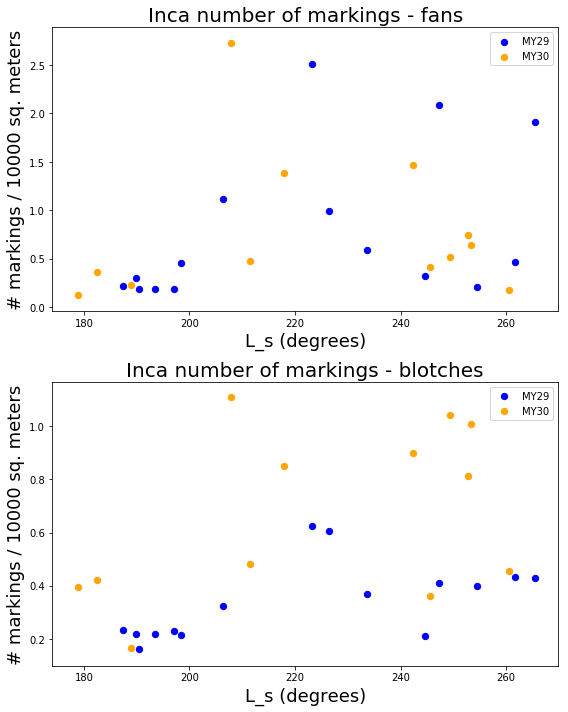

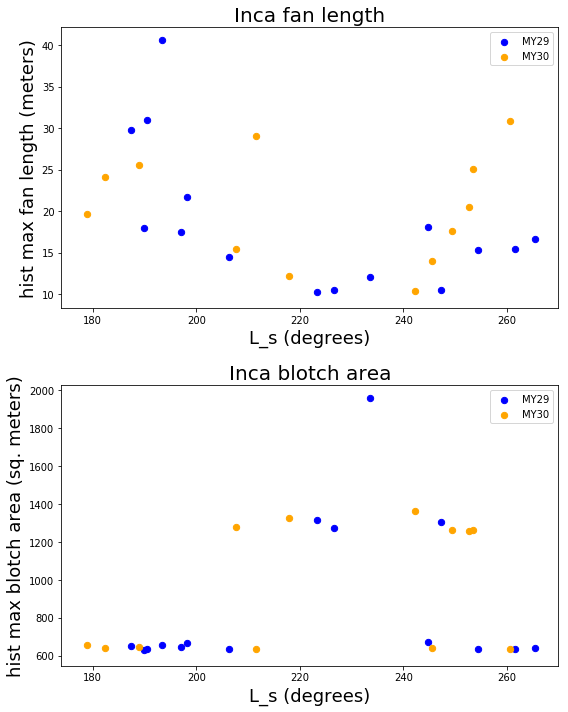

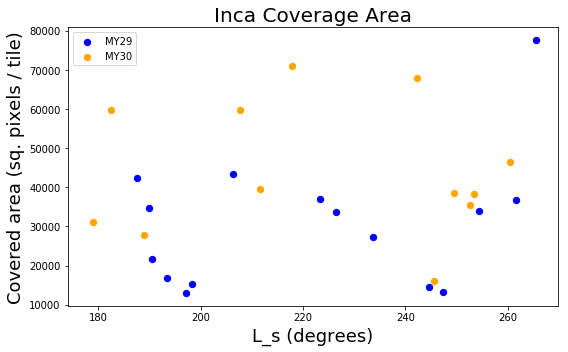

In [228]:
# plot data

txtfile = open('inca_tiles.txt', 'w')
for item in tile_log:
  txtfile.write("%s\n" % item)

s = 40
season_split = len(meta[meta.season=='season2'])
plt.figure(2,figsize=(8,10))
plt.subplot(211)
plt.scatter(n_marks[:season_split,0],n_marks[:season_split,1],label='MY29',color='b',s=s)
plt.scatter(n_marks[season_split:,0],n_marks[season_split:,1],label='MY30',color='orange',s=s)
plt.legend(frameon=True)
plt.title('Inca number of markings - fans',fontsize=20)
plt.xlabel('L_s (degrees)',fontsize=18)
plt.ylabel('# markings / 10000 sq. meters',fontsize=18)
plt.subplot(212)
plt.scatter(n_marks[:season_split,0],n_marks[:season_split,2],label='MY29',color='b',s=s)
plt.scatter(n_marks[season_split:,0],n_marks[season_split:,2],label='MY30',color='orange',s=s)
plt.legend(frameon=True)
plt.title('Inca number of markings - blotches',fontsize=20)
plt.xlabel('L_s (degrees)',fontsize=18)
plt.ylabel('# markings / 10000 sq. meters',fontsize=18)
plt.tight_layout()
plt.savefig('in_n_marks.png')
plt.figure(3,figsize=(8,10))
plt.subplot(211)
plt.scatter(n_marks[:season_split,0],f_histmax[:season_split],label='MY29',color='b',s=s)
plt.scatter(n_marks[season_split:,0],f_histmax[season_split:],label='MY30',color='orange',s=s)
plt.legend(frameon=True)
plt.title('Inca fan length',fontsize=20)
plt.xlabel('L_s (degrees)',fontsize=18)
plt.ylabel('hist max fan length (meters)',fontsize=18)
plt.subplot(212)
plt.scatter(n_marks[:season_split,0],b_histmax[:season_split],label='MY29',color='b',s=s)
plt.scatter(n_marks[season_split:,0],b_histmax[season_split:],label='MY30',color='orange',s=s)
plt.legend(frameon=True)
plt.title('Inca blotch area',fontsize=20)
plt.xlabel('L_s (degrees)',fontsize=18)
plt.ylabel('hist max blotch area (sq. meters)',fontsize=18)
plt.tight_layout()
plt.savefig('in_marksize.png')
plt.figure(4,figsize=(8,5))
plt.subplot(111)
plt.scatter(n_marks[:season_split,0],img_areas[:season_split],label='MY29',color='b',s=s)
plt.scatter(n_marks[season_split:,0],img_areas[season_split:],label='MY30',color='orange',s=s)
plt.legend(frameon=True)
plt.title('Inca Coverage Area',fontsize=20)
plt.xlabel('L_s (degrees)',fontsize=18)
plt.ylabel('Covered area (sq. pixels / tile)',fontsize=18)
plt.tight_layout()
plt.savefig('in_covg.png')
plt.show()


In [200]:
print(n_marks)

[[  1.81205092e+02   6.24632569e-05   3.17150902e-05]
 [  1.81249083e+02   3.21502058e-05   5.51146384e-06]
 [  1.83549487e+02   5.14403292e-05   1.28600823e-05]
 [  1.83593752e+02   4.96031746e-05   4.89907897e-06]
 [  2.07750946e+02   5.14403292e-05   4.04174015e-05]
 [  2.14019732e+02   7.60798146e-05   9.96146058e-05]
 [  2.14641238e+02   7.66561769e-05   9.94224850e-05]
 [  2.42278661e+02   8.05814024e-05   1.04598517e-04]
 [  2.52710250e+02   2.42504409e-04   9.55320400e-05]
 [  2.52907035e+02   7.17903496e-05   7.40514629e-05]
 [  1.80310799e+02   1.25615447e-04   1.79122575e-05]
 [  1.89712746e+02   6.34301804e-05   1.40848520e-05]
 [  1.95125296e+02   1.11565389e-04   1.69018225e-05]
 [  1.99362248e+02   1.27103882e-04   3.92868448e-05]
 [  2.09241491e+02   1.13903586e-04   1.07235395e-04]
 [  2.43829437e+02   1.26524040e-04   1.24926514e-04]]


In [201]:
print(img_areas)

[  73089.78234464   94914.77475385   97967.35143335  135347.52181883
  161884.24145818  155359.4470701   148598.69752863  125990.81413832
  166829.7651835   129690.82420085  171126.81838733   59604.22091387
  152409.32189902  208020.18130478  175961.83454531  172941.54388372]


In [202]:
meta.head(20)


,binning,invalids,l_s,line_samples,lines,map_scale,north_azimuth,obsid,path,real_area,season,min_fan,min_bl
0,"[-9998, -9998, -9998, -9998, 2, 2, -9998, -999...",0.697406,181.205092,8168,37649,0.50,99.672793,ESP_011350_0945,/Users/klay6683/Dropbox/data/hirise/labels/ESP...,2.326323e+07,season2,21.0,1257.0
1,"[-9998, -9998, -9998, -9998, 4, 4, -9998, -999...",0.949729,181.249083,30049,40496,1.00,127.960688,ESP_011351_0945,/Users/klay6683/Dropbox/data/hirise/labels/ESP...,6.117331e+07,season2,11.0,315.0
2,"[-9998, -9998, -9998, -9998, 2, 2, -9998, -999...",0.839598,183.549487,14771,45258,0.50,106.472204,ESP_011403_0945,/Users/klay6683/Dropbox/data/hirise/labels/ESP...,2.680740e+07,season2,21.0,1257.0
3,"[-9998, -9998, -9998, -9998, 4, 4, -9998, -999...",0.949674,183.593752,34927,37137,1.00,134.130277,ESP_011404_0945,/Users/klay6683/Dropbox/data/hirise/labels/ESP...,6.527651e+07,season2,11.0,315.0
4,"[-9998, -9998, -9998, -9998, 2, 2, -9998, -999...",0.857730,207.750946,16916,26537,0.50,122.704475,ESP_011931_0945,/Users/klay6683/Dropbox/data/hirise/labels/ESP...,1.596621e+07,season2,21.0,1257.0
5,"[-9998, -9998, -9998, -9998, 1, 1, -9998, -999...",0.813321,214.019732,25791,34943,0.25,127.542396,ESP_012063_0945,/Users/klay6683/Dropbox/data/hirise/labels/ESP...,1.051484e+07,season2,41.0,5027.0
6,"[-9998, -9998, -9998, -9998, 1, 1, -9998, -999...",0.801042,214.641238,22962,36382,0.25,122.275837,ESP_012076_0945,/Users/klay6683/Dropbox/data/hirise/labels/ESP...,1.038813e+07,season2,41.0,5027.0
7,"[-9998, -9998, -9998, -9998, 1, 1, -9998, -999...",0.800882,242.278661,22904,36401,0.25,122.216966,ESP_012643_0945,/Users/klay6683/Dropbox/data/hirise/labels/ESP...,1.037565e+07,season2,41.0,5027.0
8,"[-9998, -9998, -9998, -9998, 2, 2, -9998, -999...",0.802872,252.710250,11634,18186,0.50,121.484434,ESP_012854_0945,/Users/klay6683/Dropbox/data/hirise/labels/ESP...,1.042691e+07,season2,21.0,1257.0
9,"[-9998, -9998, -9998, -9998, 2, 2, -9998, -999...",0.821952,252.907035,14854,16089,0.50,230.067668,ESP_012858_0855,/Users/klay6683/Dropbox/data/hirise/labels/ESP...,1.063775e+07,season2,21.0,1257.0
